In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import heapq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import nltk
import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from keras.layers import Dense,Dropout,LSTM,Embedding
from keras.preprocessing.sequence import pad_sequences

In [2]:
data = pd.read_csv('/content/Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
len(data)

14640

In [5]:
data.isna().sum()

,0
tweet_id,0
airline_sentiment,0
airline_sentiment_confidence,0
negativereason,5462
negativereason_confidence,4118
airline,0
airline_sentiment_gold,14600
name,0
negativereason_gold,14608
retweet_count,0


<Axes: xlabel='airline_sentiment', ylabel='count'>

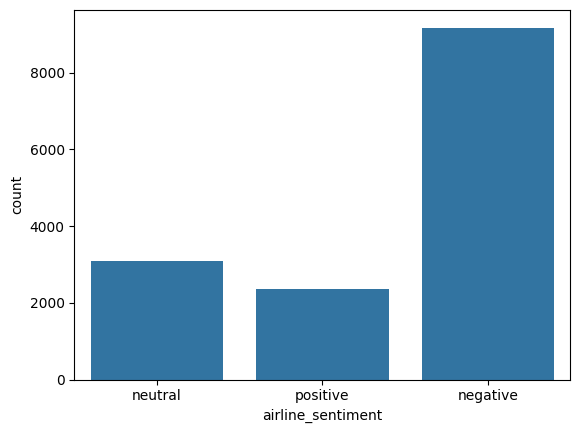

In [6]:
sns.countplot(data=data,x='airline_sentiment')

In [7]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

<Axes: xlabel='airline', ylabel='count'>

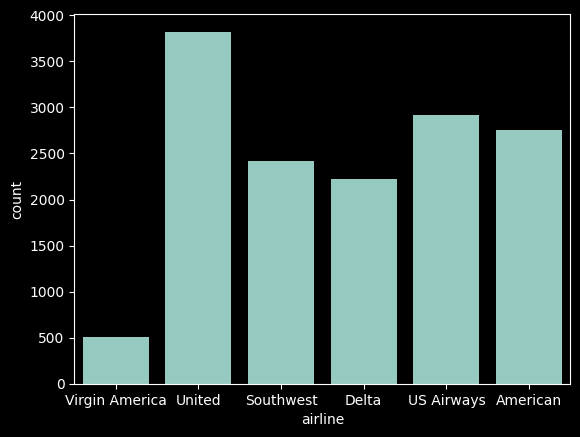

In [8]:
plt.style.use('dark_background')
sns.countplot(data=data,x='airline')

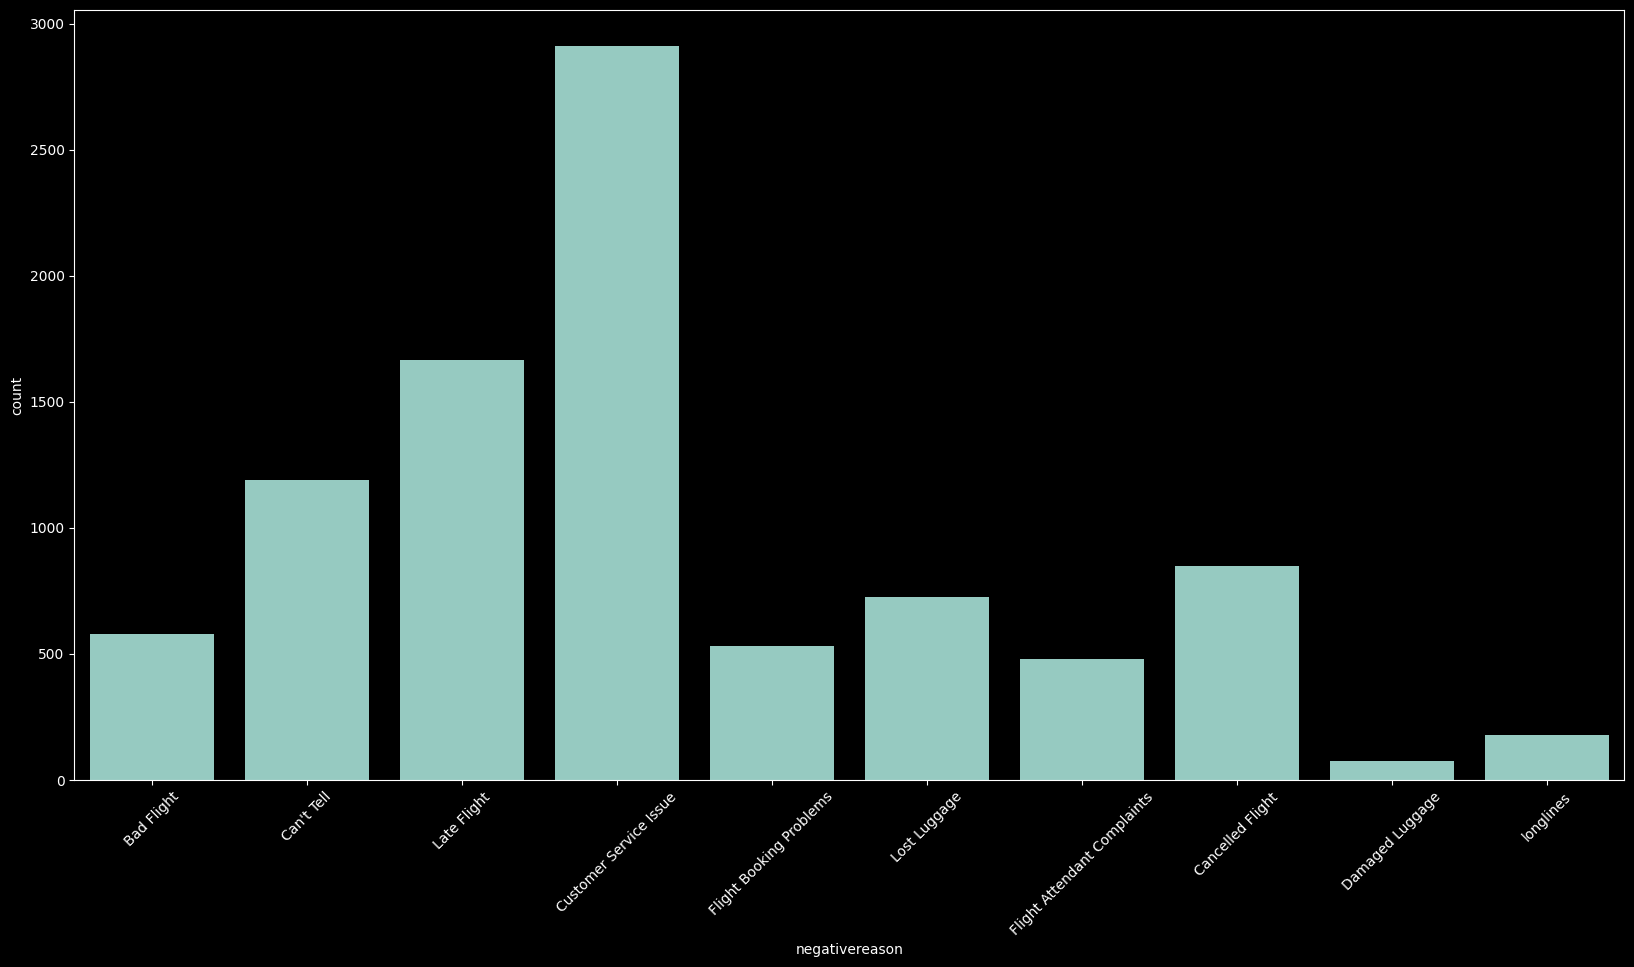

In [9]:
plt.figure(figsize=(20,10))
sns.countplot(data=data,x='negativereason')
plt.xticks(rotation=45)
plt.show()

In [10]:
data = data[['text','airline_sentiment']]
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [11]:
data['text'][5]

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
def remove_stopwords(inp_text):
    stop = nltk.corpus.stopwords.words('english')
    punc = string.punctuation
    stop.append(punc)
    whitelist = ["n't", "not", "no"]
    clean_words = []
    words = nltk.word_tokenize(inp_text)
    for word in words:
        if word not in stop or word not in whitelist and len(word)>1:
            clean_words.append(word)
    return " ".join(clean_words)

In [14]:
remove_stopwords(data['text'][5])

"@ VirginAmerica seriously would pay $ 30 flight for seats that did n't have this playing . it 's really the only bad thing about flying VA"

In [15]:
def remove_mentions(input_text):
        return re.sub(r'@ \w+', '', input_text)

In [16]:
data.text = data.text.apply(remove_stopwords).apply(remove_mentions)
data.head()

,text,airline_sentiment
0,What said .,neutral
1,plus you 've added commercials to the experie...,positive
2,I did n't today ... Must mean I need to take ...,neutral
3,it 's really aggressive to blast obnoxious ``...,negative
4,and it 's really big bad thing about it,negative


In [17]:
word2count = {}

for i in range(len(data['text'])):
    words = nltk.word_tokenize(data['text'][i])

    for word in words:
        if word not in word2count.keys():
            word2count[word] = 1
        else:
            word2count[word] += 1

In [18]:
word2count

{'What': 256,
 'said': 172,
 '.': 13552,
 'plus': 45,
 'you': 3930,
 "'ve": 467,
 'added': 20,
 'commercials': 5,
 'to': 8591,
 'the': 5795,
 'experience': 196,
 '...': 878,
 'tacky': 1,
 'I': 6357,
 'did': 474,
 "n't": 2070,
 'today': 406,
 'Must': 8,
 'mean': 54,
 'need': 473,
 'take': 261,
 'another': 234,
 'trip': 205,
 '!': 5312,
 'it': 2084,
 "'s": 1494,
 'really': 228,
 'aggressive': 3,
 'blast': 2,
 'obnoxious': 2,
 '``': 924,
 'entertainment': 23,
 'in': 2479,
 'your': 1551,
 'guests': 4,
 "'": 94,
 'faces': 3,
 '&': 823,
 'amp': 683,
 ';': 956,
 'they': 619,
 'have': 1651,
 'little': 67,
 'recourse': 5,
 'and': 3576,
 'big': 53,
 'bad': 160,
 'thing': 69,
 'about': 493,
 'seriously': 49,
 'would': 559,
 'pay': 126,
 '$': 432,
 '30': 112,
 'flight': 3163,
 'for': 3953,
 'seats': 198,
 'that': 1578,
 'this': 1172,
 'playing': 8,
 'only': 290,
 'flying': 290,
 'VA': 7,
 'yes': 163,
 ',': 4156,
 'nearly': 13,
 'every': 93,
 'time': 751,
 'fly': 362,
 'VX': 7,
 '“': 193,
 'ear': 2

In [19]:
print("Vocabluray of our corpus is: {}".format(len(word2count)))

Vocabluray of our corpus is: 18986


In [20]:
word_freq = heapq.nlargest(10000,word2count,key=word2count.get)
word_freq[:15]

['.',
 'to',
 'I',
 'the',
 '!',
 '?',
 ',',
 'for',
 'you',
 'on',
 '#',
 'and',
 'flight',
 'my',
 'is']

In [21]:
vocab_size = len(word_freq)

In [22]:
onehot_text = []
for sentences in data['text']:
    Z = one_hot(sentences,vocab_size)
    onehot_text.append(Z)

In [23]:
onehot_text[:5]

[[6822, 7515],
 [1158, 5725, 1209, 1955, 4370, 7874, 3345, 2166, 2106],
 [2690, 6934, 1792, 6520, 9762, 2045, 2690, 7179, 7874, 9646, 4330, 1746],
 [4538,
  2266,
  6636,
  2353,
  7874,
  3839,
  1354,
  2189,
  3951,
  2308,
  1260,
  1318,
  182,
  2799,
  4953,
  8784,
  2751,
  9707,
  9802],
 [7167, 4538, 2266, 6636, 1714, 8849, 701, 6164, 4538]]

In [24]:
max(len(s) for s in onehot_text)

34

In [25]:
embedded_sents = pad_sequences(onehot_text,padding='pre',maxlen=34)

In [26]:
embedded_sents[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 6822,
        7515],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1158, 5725, 1209, 1955, 4370, 7874, 3345, 2166,
        2106],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        2690, 6934, 1792, 6520, 9762, 2045, 2690, 7179, 7874, 9646, 4330,
        1746],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 4538, 2266, 6636, 2353, 7874, 3839, 1354,
        2189, 3951, 2308, 1260, 1318,  182, 2799, 4953, 8784, 2751, 9707,
        9802],
       [   0,    0,    0,    0,    0,    0,    0,   

In [27]:
labels = data['airline_sentiment']
labels

,airline_sentiment
0,neutral
1,positive
2,neutral
3,negative
4,negative
...,...
14635,positive
14636,negative
14637,neutral
14638,negative


In [28]:
lb = LabelBinarizer()

In [29]:
labels = lb.fit_transform(labels)
labels

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [30]:
X = embedded_sents
y = labels

In [31]:
X = np.asarray(X)
y = np.asarray(y)

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [33]:
X_train.shape

(11712, 34)

In [34]:
X_test.shape

(2928, 34)

# Traditional RNN Model

In [ ]:
from tensorflow.keras.layers import SimpleRNN,Input,BatchNormalization
from keras.regularizers import l2
model = Sequential()
model.add(Input(shape=(34,)))
model.add(Embedding(input_dim=10000, output_dim=128))


model.add(SimpleRNN(128, return_sequences=True,kernel_regularizer=l2(1e-4),recurrent_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(SimpleRNN(64,kernel_regularizer=l2(1e-4),recurrent_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 34, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 34, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 34, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,334,723 (5.09 MB)

 Trainable params: 1,334,339 (5.09 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])

In [40]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=5)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.2,epochs=100,batch_size=64,callbacks=[early_stop])

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.4460 - loss: 1.3057 - precision: 0.4581 - recall: 0.3560 - val_accuracy: 0.6159 - val_loss: 1.0099 - val_precision: 0.8085 - val_recall: 0.0162
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5801 - loss: 1.0525 - precision: 0.6095 - recall: 0.4724 - val_accuracy: 0.6159 - val_loss: 0.9915 - val_precision: 0.6159 - val_recall: 0.6159
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6077 - loss: 1.0207 - precision: 0.6254 - recall: 0.5125 - val_accuracy: 0.6159 - val_loss: 1.0040 - val_precision: 0.6719 - val_recall: 0.2936
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6303 - loss: 0.9867 - precision: 0.6326 - recall: 0.5655 - val_accuracy: 0.6159 - val_loss: 1.0028 - val_precision: 0.7469 - val_recall: 0.1033
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6360 - loss: 0.9694 - precision: 0.6369 - recall: 0.5900 - val_accuracy: 0.6159 - val_

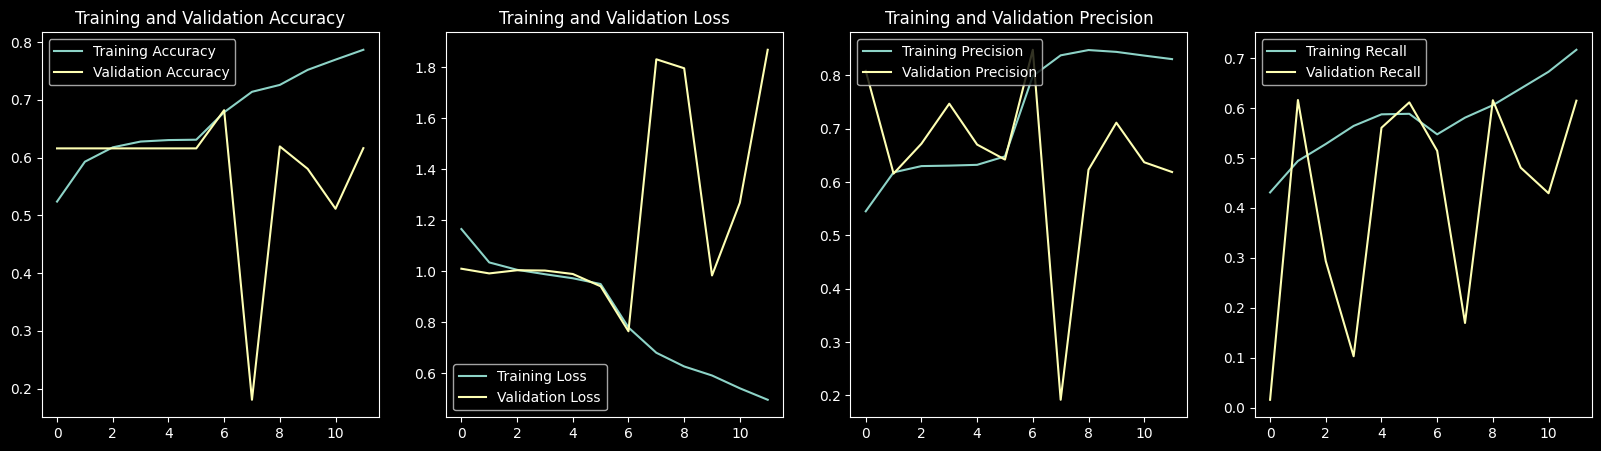

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
pre = history.history['precision']
val_pre = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']
epochs_range = range(len(acc))
plt.figure(figsize=(20, 5))


plt.subplot(1, 4, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 4, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.subplot(1,4,3)
plt.plot(epochs_range,pre,label='Training Precision')
plt.plot(epochs_range,val_pre,label='Validation Precision')
plt.legend(loc='upper left')
plt.title('Training and Validation Precision')

plt.subplot(1,4,4)
plt.plot(epochs_range,rec,label='Training Recall')
plt.plot(epochs_range,val_rec,label='Validation Recall')
plt.legend(loc='upper left')
plt.show()

- even with regularization + dropout, SimpleRNN is too weak + unstable for text classification.
- RNNs suffer from vanishing/exploding gradients and don’t capture longer dependencies well.

# LSTM RNN Model

In [37]:
from keras.layers import BatchNormalization
model1 = Sequential()

model1.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=34))
model1.add(Dropout(0.3))

model1.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model1.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))

model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

model1.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','precision','recall'])

In [42]:
history1 = model1.fit(X_train,y_train,validation_split=0.2,epochs=30,batch_size=64,callbacks=[early_stop])

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - accuracy: 0.6776 - loss: 0.7595 - precision: 0.7700 - recall: 0.5528 - val_accuracy: 0.6180 - val_loss: 0.8506 - val_precision: 0.6180 - val_recall: 0.6180
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.7675 - loss: 0.5745 - precision: 0.8065 - recall: 0.7096 - val_accuracy: 0.6240 - val_loss: 0.7566 - val_precision: 0.6534 - val_recall: 0.6172
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 244ms/step - accuracy: 0.8286 - loss: 0.4556 - precision: 0.8538 - recall: 0.7956 - val_accuracy: 0.7405 - val_loss: 0.6317 - val_precision: 0.7790 - val_recall: 0.6889
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.8555 - loss: 0.3873 - precision: 0.8737 - recall: 0.8314 - val_accuracy: 0.7559 - val_loss: 0.6330 - val_precision: 0.7765 - val_recall: 0.7192
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.8699 - loss: 0.3486 - precision: 0.8858 - recall: 0.8562 - val_accuracy: 0.7512

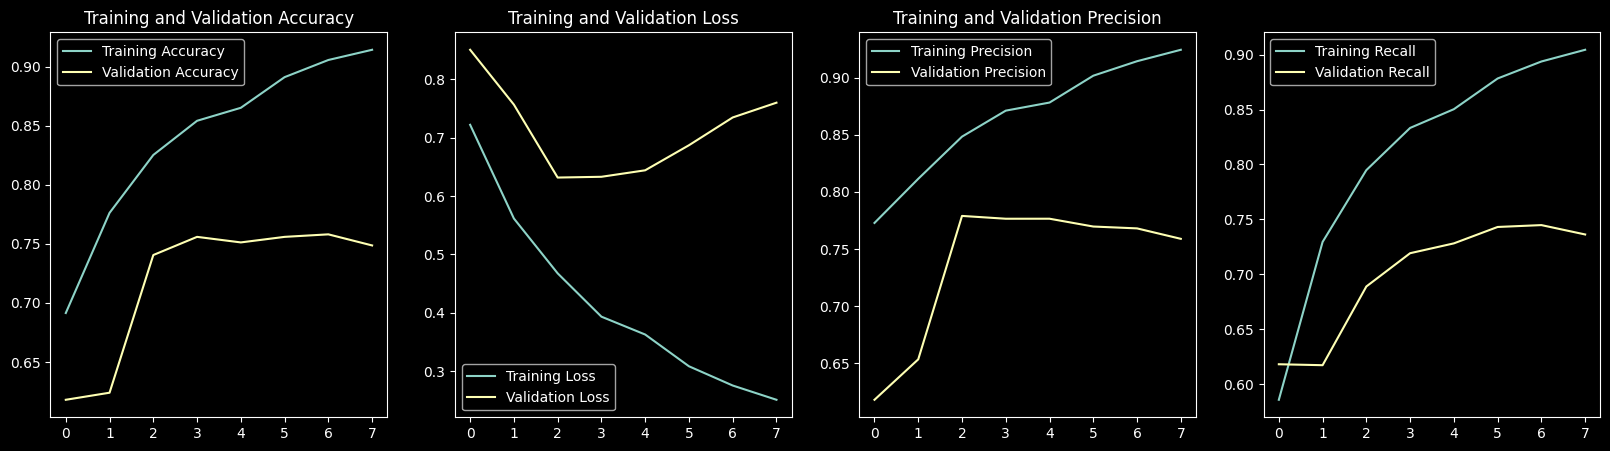

In [43]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
pre = history1.history['precision']
val_pre = history1.history['val_precision']
rec = history1.history['recall']
val_rec = history1.history['val_recall']
epochs_range = range(len(acc))
plt.figure(figsize=(20, 5))


plt.subplot(1, 4, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 4, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.subplot(1,4,3)
plt.plot(epochs_range,pre,label='Training Precision')
plt.plot(epochs_range,val_pre,label='Validation Precision')
plt.legend(loc='upper left')
plt.title('Training and Validation Precision')

plt.subplot(1,4,4)
plt.plot(epochs_range,rec,label='Training Recall')
plt.plot(epochs_range,val_rec,label='Validation Recall')
plt.legend(loc='upper left')
plt.show()

Test Accuracy of LSTM RNN Model

In [45]:
score_lstm = model1.evaluate(X_test,y_test)
score_lstm

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7588 - loss: 0.7279 - precision: 0.7681 - recall: 0.7461


[0.7670227289199829, 0.751366138458252, 0.7595379948616028, 0.7411202192306519]